### Targeted RM Mode

This catalog compares the properties of clusters using targeted RM centered at SPT locations. 

Features:
* Compares the RM of the matched clusters. 
* For the unmatched clusters check for richness and the masking fraction. 
* **What other features do you want to test?**

### Mumbo Jumbo Import Statements and Params Definition

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from glob import glob
import numpy as np
import healpy as hp
import struct

import setup
from astropy.table import Table
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy.io import fits

import pandas as pd
from tqdm import tqdm
import math

import pickle
from matched_clusters import matched_clusters

In [3]:
#Plotting params
#Plotting parameters
import matplotlib as mpl

mpl.rcParams['xtick.direction'], mpl.rcParams['ytick.direction'] = 'in', 'in'
mpl.rcParams['xtick.major.size'], mpl.rcParams['xtick.minor.size'] = 14, 8
mpl.rcParams['xtick.major.width'], mpl.rcParams['xtick.minor.width'] = 1.2, 0.8
mpl.rcParams['xtick.major.pad'], mpl.rcParams['xtick.minor.pad'] = 10, 10
mpl.rcParams['ytick.major.size'], mpl.rcParams['ytick.minor.size'] = 14, 8
mpl.rcParams['ytick.major.width'], mpl.rcParams['ytick.minor.width'] = 1.2, 0.8
mpl.rcParams['xtick.labelsize'], mpl.rcParams['ytick.labelsize'] = 20, 20

# Parameters used in this module
# One dictionary to store default values
# Another that user can view/change as necessary
Default_Params = {'default_cmap'   : plt.cm.coolwarm,
                  'title_fontsize' : 25,
                  'legend_fontsize': 22,
                  'xlabel_fontsize': 30,
                  'ylabel_fontsize': 30,
                  'scatter_factor' : 1.0}

Params = Default_Params.copy()

In [4]:
##Setting up directories
datadir = setup.data_home_dir()
outpdir = setup.output_home_dir()
bigdatadir = setup.bigdata_home_dir()

## The Real Deal

### Importing the Catalogs

In [5]:
#DES-SPT matched catalog
matched_pkl = outpdir + 'matched_pol100_lgt5_vl50_dsep1000_deltaz0.1.pkl'

with open(matched_pkl, 'rb') as inp:
    matched_catalog = pickle.load(inp)
    
top_match = matched_catalog.get_match_top_df()
no_match = matched_catalog.get_nomatch_df()

In [6]:
print(no_match.columns)
matched_catalog.get_num_match()

Index(['SPT_ID', 'RA_SPT', 'DEC_SPT', 'xi', 'theta_core', 'Z_SPT',
       'redshift_unc', 'M500', 'M500_lerr', 'M500_uerr', 'imaging', 'P_blank',
       'FIELD'],
      dtype='object')


59

In [8]:
#Import the Target SPT Catalog
redM_target = datadir + 'redMaPPer/y3_gold_2.2.1_wide_sofcol_run2_sptpol100d_092821_lambda_chisq.csv'
#redM_target = fits.open(redM_target)
#redM_target = redM_target[1].data
redM_target = pd.read_csv(redM_target)
print(redM_target.columns)

Index(['MEM_MATCH_ID', 'RA', 'DEC', 'Z', 'SPT_ID', 'LAMBDA_CHISQ',
       'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED',
       'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK',
       'Z_LAMBDA', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ',
       'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA',
       'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW',
       'Z_LAMBDA_E_RAW', 'P_BCG', 'BCG_SPEC_Z', 'LIM_EXPTIME',
       'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD'],
      dtype='object')


### Comparison of no match properties
* Redshift comparison
* LAMBDA_CHISQ
* MASKFRAC

In [14]:
no_match_merge = pd.merge(left=no_match, right=redM_target, how='left', left_on='SPT_ID', right_on='SPT_ID')

In [15]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
#Discretize the MASKFRAC
colors = ["darkgreen", "palegreen"]
cmap=LinearSegmentedColormap.from_list("", colors)
bounds = [0., 0.2, 0.4, 0.6, 0.8, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

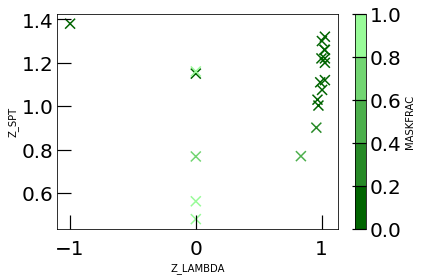

In [16]:
#Redshift comparison
plt.figure(tight_layout=True)
s = plt.scatter(no_match_merge.Z_LAMBDA, no_match_merge.Z_SPT, c=no_match_merge.MASKFRAC, cmap=cmap, norm=norm, s=100, marker='x')
cb = plt.colorbar(s)
plt.xlabel('Z_LAMBDA'); plt.ylabel('Z_SPT')
cb.set_label('MASKFRAC')
#plt.savefig('targetedRM_sptpol100_nomatch_redshift.png')
plt.show()

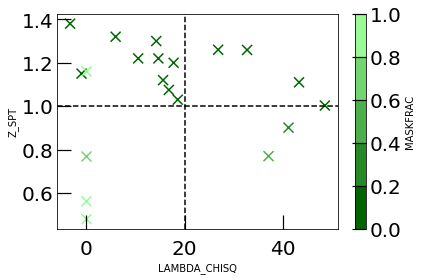

In [17]:
#LAMBDA CHISQ
plt.figure(tight_layout=True)
s = plt.scatter(no_match_merge.LAMBDA_CHISQ, no_match_merge.Z_SPT, c=no_match_merge.MASKFRAC, cmap=cmap, norm=norm, s=100, marker='x')
plt.xlabel('LAMBDA_CHISQ'); plt.ylabel('Z_SPT')
cb = plt.colorbar(s)
cb.set_label('MASKFRAC')
#plt.set_cmap('gist_gray')
plt.axvline(20, linestyle='dashed', color='black')
plt.axhline(1.0, linestyle='dashed', color='black')
#plt.savefig('targetedRM_sptpol100d_nomatch_dist.png')
plt.show()

In [18]:
no_match_merge.sort_values(by='LAMBDA_CHISQ', ascending=True)[['SPT_ID', 'RA_SPT', 'DEC_SPT', 'LAMBDA_CHISQ', 'xi', 'Z_SPT', 'MASKFRAC']]

,SPT_ID,RA_SPT,DEC_SPT,LAMBDA_CHISQ,xi,Z_SPT,MASKFRAC
10,SPT-CLJ2331-5736,352.899090,-57.614283,-3.329798,8.401972,1.380000,0.010006
1,SPT-CLJ0002-5557,0.504762,-55.962350,-1.000000,7.217852,1.150000,0.004464
2,SPT-CLJ2259-5301,344.828450,-53.030793,0.000000,5.079853,1.160000,0.989245
4,SPT-CLJ2310-5919,347.569560,-59.320252,0.000000,6.119353,0.768477,0.779324
7,SPT-CLJ2320-5807,350.069380,-58.131121,0.000000,5.796733,0.562172,0.834262
15,SPT-CLJ2341-5640,355.453470,-56.667843,0.000000,5.934129,0.480004,0.812941
18,SPT-CLJ2355-5514,358.866850,-55.249732,5.938398,4.913901,1.320000,0.148444
13,SPT-CLJ2336-5252,354.087700,-52.872471,10.530146,6.743971,1.220000,0.000000
8,SPT-CLJ2323-5752,350.878720,-57.883099,14.206594,5.142548,1.300000,0.009390
19,SPT-CLJ2355-6002,358.794200,-60.042788,14.633734,4.778688,1.220000,0.021481


## Comparison of the matched clusters

To append onto the top_match DF the targeted RM:
* Maskfrac
* LAMBDA_CHISQ
* LAMBDA_Z

Comparison plots:
Think about this.

In [19]:
redM_target_append = pd.DataFrame.copy(redM_target[["SPT_ID", "LAMBDA_CHISQ", "Z_LAMBDA", "MASKFRAC"]])
redM_target_append.rename(columns={"LAMBDA_CHISQ": "LAMBDA_CHISQ_TARG", "Z_LAMBDA": "Z_LAMBDA_TARG", "MASKFRAC": "MASKFRAC_TARG"}, inplace=True)

In [20]:
top_match_merge = pd.merge(left=top_match, right=redM_target_append, how='left', left_on='SPT_ID', right_on='SPT_ID')

In [21]:
print([top_match_merge.columns[i] for i, col  in enumerate(top_match_merge.columns)])

['SPT_ID', 'RA_SPT', 'DEC_SPT', 'xi', 'theta_core', 'Z_SPT', 'redshift_unc', 'M500', 'M500_lerr', 'M500_uerr', 'imaging', 'P_blank', 'FIELD', 'MEM_MATCH_ID', 'RA_REDM', 'DEC_REDM', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z_REDM', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC', 'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ', 'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE', 'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG', 'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT', 'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT', 'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT', 'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG',

#### Filter values

In [22]:
mask = top_match_merge.LAMBDA_CHISQ  - top_match_merge.LAMBDA_CHISQ_TARG > 10
top_match_merge[mask][['SPT_ID', 'RA_SPT', 'DEC_SPT', 'LAMBDA_CHISQ',  'LAMBDA_CHISQ_TARG', 'xi', 'Z_SPT', 'MASKFRAC']]
#top_match_merge.sort_values(by='LAMBDA_CHISQ_TARG')[['SPT_ID', 'RA_SPT', 'DEC_SPT', 'LAMBDA_CHISQ',  'LAMBDA_CHISQ_TARG', 'xi', 'Z_SPT', 'MASKFRAC']]

,SPT_ID,RA_SPT,DEC_SPT,LAMBDA_CHISQ,LAMBDA_CHISQ_TARG,xi,Z_SPT,MASKFRAC
2,SPT-CLJ0001-5440,0.413165,-54.669517,85.264270,44.563995,9.110645,0.820000,0.007656
12,SPT-CLJ2304-5718,346.108040,-57.309929,30.590437,18.264418,6.252863,0.897056,0.003537
18,SPT-CLJ2311-5820,347.995480,-58.336319,33.046486,-1.000000,5.469923,0.930000,0.017736
19,SPT-CLJ2312-5101,348.242120,-51.029217,41.772330,30.788752,4.812294,0.350000,0.007378
20,SPT-CLJ2314-5554,348.535490,-55.901563,31.048086,19.698385,4.879810,0.711617,0.009202
31,SPT-CLJ2327-5137,351.780070,-51.623137,72.221260,59.468100,6.222599,0.338100,0.012916
32,SPT-CLJ2328-5533,352.178020,-55.560460,60.398660,48.591310,7.876473,0.772674,0.008596
33,SPT-CLJ2329-5831,352.471240,-58.524097,64.181890,39.224754,10.805716,0.719200,0.006505
55,SPT-CLJ2355-5850,358.961900,-58.846784,46.928513,30.514162,4.935186,0.970000,0.005303


In [23]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
#Discretize the MASKFRAC
colors = ["darkgreen", "palegreen"]
cmap=LinearSegmentedColormap.from_list("", colors)
bounds = [0., 0.05, 0.1, 0.15, 0.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

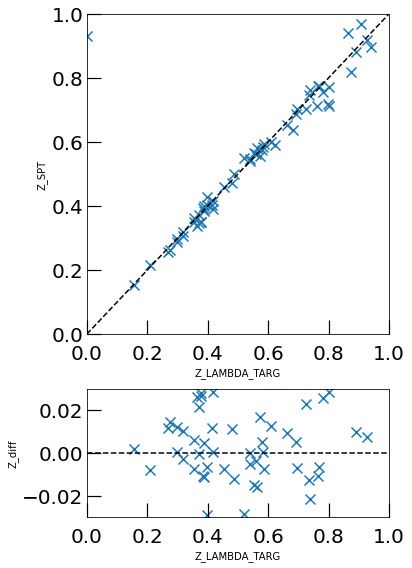

In [24]:
#Difference between Z_LAMBDA and Z_LAMBDA TARG
x = np.linspace(0,2,100)

f, (a0, a1) = plt.subplots(2, 1, figsize=(6,8), gridspec_kw={'height_ratios': [2.5,1]}, tight_layout=True)
s = a0.scatter(top_match_merge.Z_LAMBDA_TARG, top_match_merge.Z_SPT, s=100, marker='x')
a0.plot(x,x, linestyle='dashed', color='black')
a0.set_xlabel('Z_LAMBDA_TARG'); a0.set_ylabel('Z_SPT')
a0.set_xlim([0,1]); a0.set_ylim([0,1])

#Plotting the difference 
z_diff = top_match_merge.Z_LAMBDA_TARG - top_match_merge.Z_SPT
a1.scatter(top_match_merge.Z_LAMBDA_TARG, z_diff, s=100, marker='x')
a1.set_xlabel('Z_LAMBDA_TARG'); a1.set_ylabel('Z_diff')
a1.set_xlim([0,1]); a1.set_ylim([-0.03,0.03])
a1.axhline(0, linestyle='dashed', color='black')
#plt.savefig('targetedRM_sptpol100_topmatch_zspt_vs_zlambda_targ.png')

plt.show()

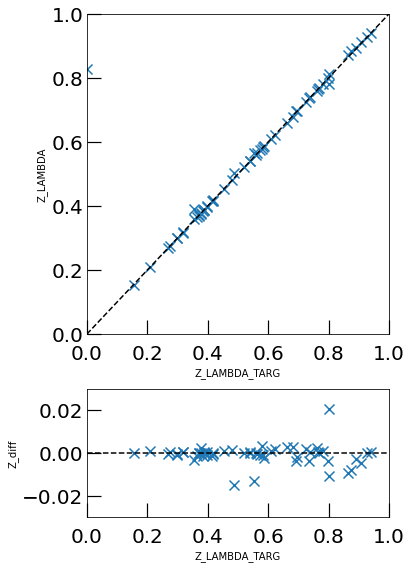

In [25]:
#Difference between Z_LAMBDA and Z_LAMBDA TARG
x = np.linspace(0,2,100)

f, (a0, a1) = plt.subplots(2, 1, figsize=(6,8), gridspec_kw={'height_ratios': [2.5,1]}, tight_layout=True)
s = a0.scatter(top_match_merge.Z_LAMBDA_TARG, top_match_merge.Z_LAMBDA, s=100, marker='x')
a0.plot(x,x, linestyle='dashed', color='black')
a0.set_xlabel('Z_LAMBDA_TARG'); a0.set_ylabel('Z_LAMBDA')
a0.set_xlim([0,1]); a0.set_ylim([0,1])

#Plotting the difference 
z_diff = top_match_merge.Z_LAMBDA_TARG - top_match_merge.Z_LAMBDA
a1.scatter(top_match_merge.Z_LAMBDA_TARG, z_diff, s=100, marker='x')
a1.set_xlabel('Z_LAMBDA_TARG'); a1.set_ylabel('Z_diff')
a1.set_xlim([0,1]); a1.set_ylim([-0.03,0.03])
a1.axhline(0, linestyle='dashed', color='black')
#plt.savefig('targetedRM_sptpol100_topmatch_zlambda_vs_zlambda_targ.png')

plt.show()

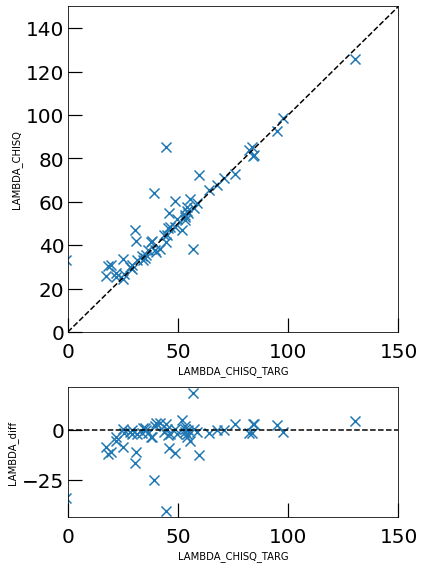

In [26]:
#Richness comparison 
x = np.linspace(0,200,100)

f, (a0, a1) = plt.subplots(2, 1, figsize=(6,8), gridspec_kw={'height_ratios': [2.5,1]}, tight_layout=True)
s = a0.scatter(top_match_merge.LAMBDA_CHISQ_TARG, top_match_merge.LAMBDA_CHISQ, s=100, marker='x')
a0.plot(x,x, linestyle='dashed', color='black')
a0.set_xlabel('LAMBDA_CHISQ_TARG'); a0.set_ylabel('LAMBDA_CHISQ')
a0.set_xlim([0,150]); a0.set_ylim([0,150])

#Plotting the difference 
lambda_diff = top_match_merge.LAMBDA_CHISQ_TARG - top_match_merge.LAMBDA_CHISQ
a1.scatter(top_match_merge.LAMBDA_CHISQ_TARG, lambda_diff, s=100, marker='x')
a1.set_xlabel('LAMBDA_CHISQ_TARG'); a1.set_ylabel('LAMBDA_diff')
a1.axhline(0, linestyle='dashed', color='black')
a1.set_xlim([0,150])

#plt.savefig('targetedRM_sptpol100_topmatch_lambda_vs_lambda_targ.png')

plt.show()

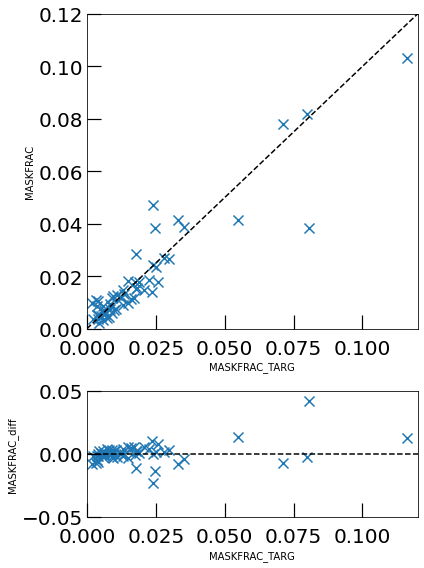

In [27]:
#Masking fraction comparison
#Richness comparison 
x = np.linspace(0,0.2,100)

f, (a0, a1) = plt.subplots(2, 1, figsize=(6,8), gridspec_kw={'height_ratios': [2.5,1]}, tight_layout=True)
s = a0.scatter(top_match_merge.MASKFRAC_TARG, top_match_merge.MASKFRAC, s=100, marker='x')
a0.plot(x,x, linestyle='dashed', color='black')
a0.set_xlabel('MASKFRAC_TARG'); a0.set_ylabel('MASKFRAC')
a0.set_xlim([0,0.12]); a0.set_ylim([0,0.12])

#Plotting the difference 
MASKFRAC_diff = top_match_merge.MASKFRAC_TARG - top_match_merge.MASKFRAC
a1.scatter(top_match_merge.MASKFRAC_TARG, MASKFRAC_diff, s=100, marker='x')
a1.set_xlabel('MASKFRAC_TARG'); a1.set_ylabel('MASKFRAC_diff')
a1.axhline(0, linestyle='dashed', color='black')
a1.set_xlim([0,0.12]); a1.set_ylim([-0.05,0.05])

#plt.savefig('targetedRM_sptpol100_topmatch_maskfrac_vs_maskfrac_targ.png')
plt.show()

## Testing the Z Map

There are duplicate HPIX values in teh RM_zmax file. 

The last data entry is corrupt. 

            HPIX	FRACGOOD	ZMAX	MASKFRAC_EST

22841161	8.281250e-01	  0.950000	  0.00	  NaN

In [28]:
RM_zmax_file = bigdatadir + 'redMaPPer/' + 'y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl02_vlim_zmask.csv'

In [29]:
RM_zmax = pd.read_csv(RM_zmax_file)

In [43]:
#Drop duplicated
print("Length of file is", len(RM_zmax)) 
RM_zmax.drop_duplicates(subset=['HPIX'], inplace=True)
print("After dropping duplicated length of file is", len(RM_zmax)) 

Length of file is 22841161
After dropping duplicated length of file is 22841161


In [44]:
#Converting HPIX into integer
RM_zmax['HPIX'] = RM_zmax['HPIX'].astype(int)

In [45]:
# Remove NAN values
print("Length of file is", len(RM_zmax)) 
RM_zmax.dropna(inplace=True)
print("After removing NAN length of file is", len(RM_zmax)) 

Length of file is 22841161
After removing NAN length of file is 22841161


In [46]:
#Replace NAN values with 0
print(RM_zmax['FRACGOOD'].isnull().sum())
RM_zmax['FRACGOOD'] = RM_zmax['FRACGOOD'].fillna(0)

0


In [47]:
RM_zmax.tail()

,HPIX,FRACGOOD,ZMAX,MASKFRAC_EST
22841156,194096450,0.765625,0.472,0.0
22841157,194096451,0.765625,0.472,0.0
22841158,194096452,0.765625,0.473,0.0
22841159,194096453,0.765625,0.473,0.0
22841160,194096454,0.765625,0.474,0.0


In [48]:
topmatch_pix=hp.ang2pix(4096, top_match.RA_SPT.values, top_match.DEC_SPT.values, lonlat=True)
nomatch_pix =hp.ang2pix(4096, no_match.RA_SPT.values, no_match.DEC_SPT.values, lonlat=True)

In [49]:
top_match['HPIX'] = topmatch_pix
no_match['HPIX'] = nomatch_pix

In [50]:
top_match.head()

,SPT_ID,RA_SPT,DEC_SPT,xi,theta_core,Z_SPT,redshift_unc,M500,M500_lerr,M500_uerr,...,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,LIM_EXPTIME,LIM_LIMMAG_DERED,LIM_LIMMAG,LIM_LIMMAG_HARD,MASKGAL_INDEX,propD_sep,Delta_Z,HPIX
0,SPT-CLJ0000-5748,0.247868,-57.808061,14.644361,0.25,0.701900,0.000000,4.721501,-0.589862,0.503771,...,0.694805,0.008859,0.236266,22.345320,22.345320,23.559084,5.0,45.5383,-0.0113351,185853115
1,SPT-CLJ0000-6020,0.032286,-60.340474,7.183841,0.50,0.761757,0.048809,2.900750,-0.455428,0.385271,...,0.740317,0.015197,0.161187,22.056208,22.056208,23.559084,35.0,71.5065,-0.011634,188132208
2,SPT-CLJ0001-5440,0.413165,-54.669517,9.110645,0.50,0.820000,0.081900,3.368699,-0.478318,0.397177,...,0.885844,0.005302,0.257202,22.409510,22.409510,23.559084,25.0,113.17,0.0872212,182788645
3,SPT-CLJ0001-5614,0.486184,-56.240999,5.414786,0.25,0.428054,0.036073,2.554641,-0.455476,0.445880,...,0.400818,0.007054,0.276923,22.465366,22.465366,23.559084,23.0,62.3842,-0.0211368,184349643
8,SPT-CLJ2259-5349,344.794070,-53.823576,7.174465,0.25,0.257540,0.022577,3.282470,-0.515476,0.437596,...,0.269425,0.004520,0.343176,22.627544,22.627544,23.559084,69.0,64.805,0.0124983,181925845


In [51]:
RM_zmax_topmatch = RM_zmax[RM_zmax.HPIX.isin(topmatch_pix)]
RM_zmax_nomatch = RM_zmax[RM_zmax.HPIX.isin(nomatch_pix)]

In [52]:
top_match_zmax = pd.merge(left=top_match, right=RM_zmax_topmatch, how='left', left_on='HPIX', right_on='HPIX')
no_match_zmax = pd.merge(left=no_match, right=RM_zmax_nomatch, how='left', left_on='HPIX', right_on='HPIX')

In [53]:
## Find NAN values. Indicates No matches
print(no_match_zmax['FRACGOOD'].isnull().sum())
no_match_zmax['FRACGOOD'] = no_match_zmax['FRACGOOD'].fillna(0)

print(top_match_zmax['FRACGOOD'].isnull().sum())
top_match_zmax['FRACGOOD'] = top_match_zmax['FRACGOOD'].fillna(0)

5
0


In [54]:
no_match_zmax.head()

,SPT_ID,RA_SPT,DEC_SPT,xi,theta_core,Z_SPT,redshift_unc,M500,M500_lerr,M500_uerr,imaging,P_blank,FIELD,HPIX,FRACGOOD,ZMAX,MASKFRAC_EST
0,SPT-CLJ0002-5017,0.651454,-50.288932,5.447203,0.25,0.901207,0.033271,2.250910,-0.408256,0.402219,1,-1.0000,SPTPOL_100d,178090872,0.953125,0.679,0.0
1,SPT-CLJ0002-5557,0.504762,-55.962350,7.217852,0.75,1.150000,0.096750,2.624150,-0.411177,0.355996,3,0.0165,SPTPOL_100d,184068796,1.000000,0.810,0.0
2,SPT-CLJ2259-5301,344.828450,-53.030793,5.079853,0.25,1.160000,0.093841,1.983135,-0.407509,0.344885,3,0.0137,SPTPOL_100d,181094895,0.000000,NaN,NaN
3,SPT-CLJ2306-5120,346.612080,-51.346487,8.112616,0.50,1.260000,0.101700,2.784230,-0.400282,0.360797,3,0.0014,SPTPOL_100d,179287938,1.000000,0.719,0.0
4,SPT-CLJ2310-5919,347.569560,-59.320252,6.119353,0.25,0.768477,0.048606,2.559710,-0.444273,0.401701,3,0.0197,SPTPOL_100d,187244101,0.000000,NaN,NaN


Text(0.5, 1.0, 'N = 59/79')

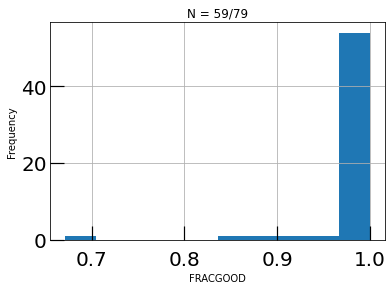

In [55]:
top_match_zmax.hist(column='FRACGOOD')
plt.xlabel('FRACGOOD'); plt.ylabel('Frequency')
plt.title('N = {:d}/{:d}'.format(len(top_match), len(no_match)+len(top_match)))
#plt.savefig('plots/topmatch_fracgood.png')

Text(0.5, 1.0, 'N = 20/79')

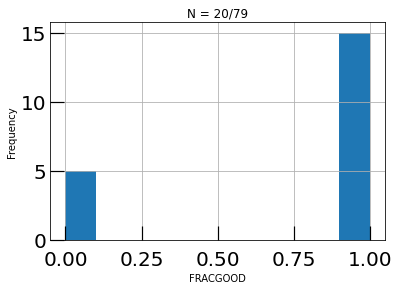

In [56]:
no_match_zmax.hist(column='FRACGOOD')
plt.xlabel('FRACGOOD'); plt.ylabel('Frequency')
plt.title('N = {:d}/{:d}'.format(len(no_match), len(no_match)+len(top_match)))
#plt.savefig('plots/nomatch_fracgood.png')

In [57]:
## Test the 5 cluster locations with NO FRACGOOD location. 
import healpy as hp
des_map = hp.pix2ang(nside=4096, ipix=RM_zmax.HPIX.values, nest=False, lonlat=True)

In [62]:
no_match_null = no_match_zmax[no_match_zmax['FRACGOOD'] == 0]
no_match_null[['SPT_ID', 'RA_SPT', 'DEC_SPT', 'xi', 'Z_SPT']]

,SPT_ID,RA_SPT,DEC_SPT,xi,Z_SPT
2,SPT-CLJ2259-5301,344.82845,-53.030793,5.079853,1.160000
4,SPT-CLJ2310-5919,347.56956,-59.320252,6.119353,0.768477
7,SPT-CLJ2320-5807,350.06938,-58.131121,5.796733,0.562172
9,SPT-CLJ2328-5550,352.03835,-55.846609,4.651302,0.770000
15,SPT-CLJ2341-5640,355.45347,-56.667843,5.934129,0.480004


In [ ]:
plt.scatter(des_map[0][::1000], des_map[1][::1000], label = 'DES Y3 map')
plt.scatter(no_match_null.RA_SPT.values, no_match_null.DEC_SPT.values, label='No NPIX match')
plt.legend()
#plt.savefig('plots/no_npix_match.png')
plt.show()

#### Comparision of Z vs ZMax

In [ ]:
x = np.linspace(0,1,100)
top_match_zmax.plot(x='Z_SPT', y='ZMAX' ,kind='scatter')
plt.plot(x,x,linestyle='dashed', color='black')
plt.title('Matched clusters')
#plt.savefig('plots/z_vs_zmax_topmatch_sptpol100.png')

In [ ]:
x = np.linspace(0,1.5,100)
no_match_zmax.plot(x='Z_SPT', y='ZMAX' ,kind='scatter')
plt.plot(x,x,linestyle='dashed', color='black')
plt.title('No match clusters')
#plt.savefig('plots/z_vs_zmax_nomatch_sptpol100.png')